# Object Detection
## Finding the Pentagon Figure on the page
### Using Python

Creating and Training a model to find the Pentagon figure on the page of the MMSE Document. This goes through a bit of the code. The feature and model creation only need to be ran once. Near the bottom there is a classifier testing code run through.


> Uses methods and modules with the SKlearn and SKImage libraries in python 
>
> --- [scikit-learn 0.19.1. (2017, October). Simple and efficient tools for data mining and data analysis](http://scikit-learn.org/stable/index.html)

In [2]:
# imports
# Import the functions to calculate feature descriptors
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
import joblib
import cv2
# To read file names
import glob
import os
import numpy as np
import random

# Import the required sklearn modules for models
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd

import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

Must create a correct file structure to save the features for training method

In [3]:
# file structure for feature ies
path = os.path.join(os.getcwd(), 'training_mmse_pentagons')
model_dir = os.path.join(path, 'models')

pos_im_path = os.path.join(path, 'pos_pent')
neg_im_path = os.path.join(path, 'neg_pent')
pos_feat_ph = os.path.join(path, "pos_feat_ph")
neg_feat_ph = os.path.join(path, "neg_feat_ph")

In using the HOG detection paramaters must be set


Parameters:	
image : (M, N[, C]) ndarray
    Input image.

orientations : int, optional
    Number of orientation bins.

pixels_per_cell : 2-tuple (int, int), optional
    Size (in pixels) of a cell.

cells_per_block : 2-tuple (int, int), optional
    Number of cells in each block.

block_norm : str {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}, optional
    Block normalization method:

In [4]:
#parameters for HOG
#reference: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
orientations = 9 # number of bins to turn image
pixels_per_cell = (8, 8)
cells_per_block = (3, 3)
square_size = 128
des_type = "HOG"

Next create the directory to save the features in

In [6]:
 # If feature directories don't exist, create them
if not os.path.isdir(pos_feat_ph):
    os.makedirs(pos_feat_ph)

# If feature directories don't exist, create them
if not os.path.isdir(neg_feat_ph):
    os.makedirs(neg_feat_ph)

Positive image feature input for the MMSE pentagon example. These are the images for classification, and they can be filled with different images.

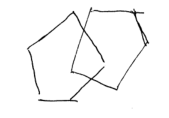

In [12]:
from IPython.display import Image

sample_pos_path = os.path.join('images', 'sample_pos.png')
Image(filename=sample_pos_path)

Negative image feature input for MMSE example

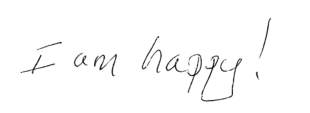

In [13]:
from IPython.display import Image
sample_neg_path = os.path.join('images', 'sample_neg.png')
Image(filename=sample_neg_path) 

For each image path in the positive directory we first read it into the im variable and convert it to graysale
Then it is resized to the "square_size" variable defined above
Finally create the HOG descriptor for the image. A 1D (flattened) array is returned.

Only needs to be run once to create the features

In [9]:
def extract_features(image_path, feature_path, square_size=square_size, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block):
    print("Calculating the descriptors for the positive samples and saving them")
    file_count = 0
    for file in glob.glob(os.path.join(image_path, "*")):
        im = cv2.imread(file, cv2.IMREAD_GRAYSCALE) #Reads image in and convers to grayscale
        im = cv2.resize(im, (square_size,square_size))
        if des_type == "HOG":
            fd, _ = hog(im, orientations, pixels_per_cell, cells_per_block, visualize = True, transform_sqrt=True)
            
        fd_name = os.path.split(file)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(feature_path, fd_name)
        joblib.dump(fd, fd_path) #dumps feature detection in the save path
        file_count += 1
    print("Processed {} images for positive features".format(file_count))
    print("Positive features saved in {}".format(feature_path))

In [10]:
#clear out the feature directories
for file in glob.glob(os.path.join(pos_feat_ph, "*")):
    os.remove(file)
for file in glob.glob(os.path.join(neg_feat_ph, "*")):
    os.remove(file)

extract_features(pos_im_path, pos_feat_ph, square_size, orientations, pixels_per_cell, cells_per_block)

Calculating the descriptors for the positive samples and saving them
Processed 1056 images for positive features
Positive features saved in /Users/awshift/Documents/general_coding/object-detector/training_mmse_pentagons/pos_feat_ph


In [11]:
extract_features(neg_im_path, neg_feat_ph, square_size, orientations, pixels_per_cell, cells_per_block)

Calculating the descriptors for the positive samples and saving them
Processed 1006 images for positive features
Positive features saved in /Users/awshift/Documents/general_coding/object-detector/training_mmse_pentagons/neg_feat_ph


# Train Classifier
## Training with linear SVM

This trains the classifier, only needs to run once in order to create the model.

In [12]:

#clear our the model directory
for file in glob.glob(os.path.join(path, "models", "*")):
    os.remove(file)

pos_feat_path =  pos_feat_ph
neg_feat_path =  neg_feat_ph

# Classifiers supported


fds = []
labels = []
# Load the positive features
for feat_path in glob.glob(os.path.join(pos_feat_path,"*.feat")):
    fd = joblib.load(feat_path)
    fds.append(fd)
    labels.append(1)

# Load the negative features
for feat_path in glob.glob(os.path.join(neg_feat_path,"*.feat")):
    fd = joblib.load(feat_path)
    fds.append(fd)
    labels.append(0)

model_path =  os.path.join(path, "models", "KNN.model") # where to save the model
clf = KNeighborsClassifier()
print("Training a KNN Classifier")
print(len(fds), len(labels))
clf.fit(fds, labels)
# If feature directories don't exist, create them
if not os.path.isdir(os.path.split(model_path)[0]):
    os.makedirs(os.path.split(model_path)[0])
joblib.dump(clf, model_path)
print("Classifier saved to {}".format(model_path))

model_path =  os.path.join(path, "models", "SVM.model") # where to save the model
clf = LinearSVC()
print("Training a SVM Classifier")
print(len(fds), len(labels))
clf.fit(fds, labels)
# If feature directories don't exist, create them
if not os.path.isdir(os.path.split(model_path)[0]):
    os.makedirs(os.path.split(model_path)[0])
joblib.dump(clf, model_path)
print("Classifier saved to {}".format(model_path))



Training a KNN Classifier
2062 2062
Classifier saved to /Users/awshift/Documents/general_coding/object-detector/training_mmse_pentagons/models/KNN.model
Training a SVM Classifier
2062 2062
Classifier saved to /Users/awshift/Documents/general_coding/object-detector/training_mmse_pentagons/models/SVM.model


# Testing Classifiers

Can use this to test different classifier models with the features. 

In [13]:
def test_classifiers(data, lables, clf):
    """
    create training objects
    """
    data = np.array(data)
    print("Total object(n) = " + str(len(data)))
    is_train = np.random.uniform(0, 1, len(data)) <= 0.8 # split randomly: train with 80%,other 20% for testing classifier
    y = np.where(np.array(labels)== 1, 1, 0)

    #set training and test data
    train_x, train_y = data[is_train], y[is_train]
    test_x, test_y = data[is_train==False], y[is_train==False]


    pca = PCA(n_components=5, svd_solver='randomized')
    print("Trainng set n = " + str(len(data[is_train])))
    print("Testing set n = " + str(len(data[is_train==False])))
    train_x = pca.fit_transform(train_x)
    test_x = pca.transform(test_x)
    clf.fit(train_x, train_y)
    df = pd.crosstab(test_y, clf.predict(test_x), rownames=["Actual"], colnames=["Predicted"])
    score = clf.score(test_x, test_y)
    print(df)
    print("Score: " + str(score))
    print("")

In [14]:
test_classifiers(fds, labels, clf)

Total object(n) = 2062
Trainng set n = 1647
Testing set n = 415
Predicted    0    1
Actual             
0          194   13
1           14  194
Score: 0.9349397590361446



In [15]:
def make_model(model_type):
    model_name = model_type + ".model"
    model_path =  os.path.join(path, "models", model_name)
    return model_path
# Classifiers supported


# fds = []
# labels = []
# # Load the positive features
# for feat_path in glob.glob(os.path.join(pos_feat_ph,"*.feat")):
#     fd = joblib.load(feat_path)
#     fds.append(fd)
#     labels.append(1)

# # Load the negative features
# for feat_path in glob.glob(os.path.join(neg_feat_ph,"*.feat")):
#     fd = joblib.load(feat_path)
#     fds.append(fd)
#     labels.append(0)

    
# ## TO actually create the models, remove the comments on joblib.dump    
# clf_type = "LIN_SVM"
# if clf_type == "LIN_SVM":
#     clf = LinearSVC()
#     print("Testing Linear SVM Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)
    

# clf_type = "KNN"
# if clf_type == "KNN":
#     clf = KNeighborsClassifier()
#     print("Testing KNN Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)

# clf_type = "RandomForest"
# if clf_type == "RandomForest":
#     clf = RandomForestClassifier(n_jobs=2)
#     print("Testing Random Forest Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)

# clf_type = "DecisionTreeCLassifier"
# if clf_type == "DecisionTreeCLassifier":
#     clf = DecisionTreeClassifier(random_state=0)
#     print("Testing Decision Tree Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)

    
# clf_type = "GaussianProcessClassifier"
# if clf_type == "GaussianProcessClassifier":
#     #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
#     clf = GaussianProcessClassifier()
#     print("Testing Gaussian Process Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)


# clf_type = "MLPClassifier"
# if clf_type == "MLPClassifier":
#     #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
#     clf = MLPClassifier(alpha=1)
#     print("Testing MLPClassifier Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)


# clf_type = "SVC"
# if clf_type == "SVC":
#     #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
#     clf = SVC()
#     print("Testing SVC Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)


# clf_type = "AdaBoost"
# if clf_type == "AdaBoost":
#     #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
#     clf = AdaBoostClassifier()
#     print("Testing AdaBoost Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)


# clf_type = "GaussianNB"
# if clf_type == "GaussianNB":
#     #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
#     clf = GaussianNB()
#     print("Testing GaussianNB Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)


# clf_type = "QuadraticDiscriminantAnalysis"
# if clf_type == "QuadraticDiscriminantAnalysis":
#     #kernel = 1.0 * RBF([1.0, 1.0])  # for GPC
#     clf = QuadraticDiscriminantAnalysis()
#     print("Testing QuadraticDiscriminantAnalysis Classifier")
#     clf.fit(fds, labels)
#     # If feature directories don't exist, create them
#     model_path = make_model(clf_type)
#     joblib.dump(clf, model_path)
#     print("Classifier saved to {}".format(model_path))
    
#     test_classifiers(fds, labels, clf)



## EXAMPLE WITH SAMPLE MMSE PAGES


## Walk the path and pull a random MMSE scanned page
Print filename and show image

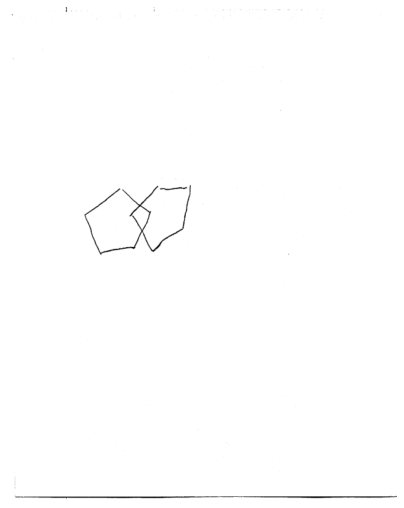

In [7]:
testing_path = os.path.join(path, r'pent_bins', r'pos_score_dir')
model_path =  os.path.join("models", "SVM.model")

# get 10 random files from the testing path
test_files = random.sample([x for x in os.listdir(testing_path) if os.path.isfile(os.path.join(testing_path, x))], k=5)
file = random.choice([x for x in os.listdir(testing_path) if os.path.isfile(os.path.join(testing_path, x))])
test_file = os.path.join(testing_path, file)
im = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(im,cmap='gray')
plt.show()

## Find the all the contours in the image using the cv2.find contours method and bound
http://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a

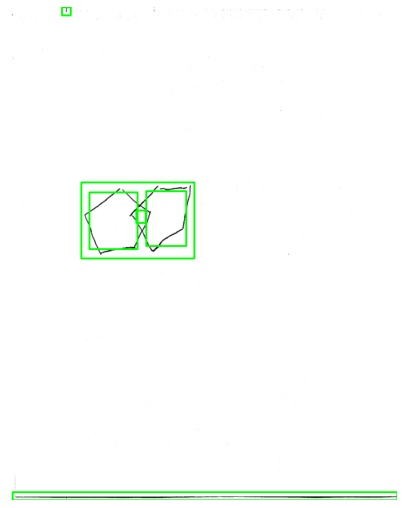

In [8]:
clone = im.copy() #clone image
color_im = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 
#preprocessing of image applying gaussianblur and thresholding OTSU
blur = cv2.GaussianBlur(clone,(5,5),0) 
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#preprocessing of image applying canny edge detection and dialtion to get all contours
edges = cv2.Canny(th3,0,255,apertureSize = 5) # Canny image 
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)) # create the kernle
edges = cv2.dilate(edges, kernel, iterations=5)


contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # find each contour
cv2.drawContours(color_im, contours, -1, (255,255,0), 3) #draw all contours

img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 

for cnt in contours:
        # get the perimeter circularity of the contours
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull,True)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)   
#img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
def detection(img, model_path):
    '''
    The detections methond using the HOG SVM algorithm
    '''
    clf = joblib.load(model_path) #prediciton method using SVM
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    im_reshape = cv2.resize(opening, (square_size,square_size)) # reduces noise on image
    fd, d = hog(im_reshape, orientations, pixels_per_cell, cells_per_block, visualize = True, transform_sqrt=True)    
    pred = clf.predict(fd.reshape(1,-1))
    # print(clf.predict_proba(fd.reshape(1,-1)))
    #if pred == 1:
    #    return clf.decision_function(fd)
    #else:
    #    return 0
    return pred
    

In [30]:
# detection_threshold = 1 # change this to change accepted detection High is above 1.5... Low is 0.5


# models = os.path.join(path, 'models')
# model_list = os.listdir(models)
# for model in model_list:
#     model_path = os.path.join(models, model)
#     print(model)
    
#     img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 
#     found_dets = []

#     for cnt in contours:
#         # get the perimeter circularity of the contours
#         hull = cv2.convexHull(cnt)
#         area = cv2.contourArea(hull)
#         perimeter = cv2.arcLength(hull,True)
#         approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
#         #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
#         if perimeter != 0:
#             x,y,w,h = cv2.boundingRect(cnt)
#             cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
#             if (h*w) > 200: # minimum area of the contour bounding box
#                 feature = clone[y:y + h, x:x + w]
#                 cd = detection(feature, model_path)
#                 # print('detection at', x,y, 'detection score:', cd)
#                 if (cd==1): #threshold for acceptance for HOG
#                     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
#                     found_dets.append((x, y, cd, w, h))
#     #img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()


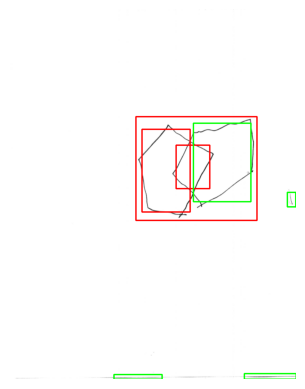

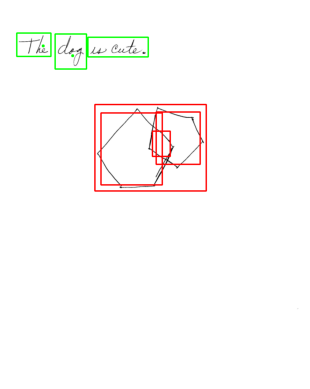

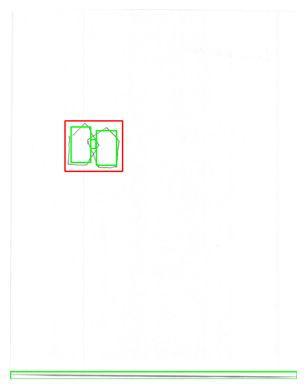

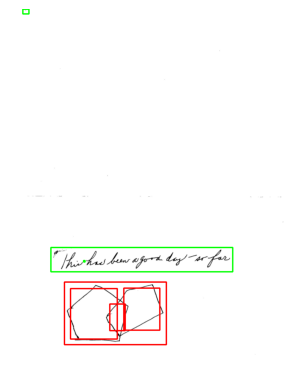

In [11]:
model_path = os.path.join(model_dir, 'SVM.model')
for f in test_files:
    test_file = os.path.join(testing_path, f)
    im = cv2.imread(test_file)
    grayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)



    clone = im.copy() #clone image
    color_im = im.copy()
    #preprocessing of image applying gaussianblur and thresholding OTSU
    blur = cv2.GaussianBlur(grayImage,(5,5),0) 
    ret3,th3 = cv2.threshold(grayImage,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #preprocessing of image applying canny edge detection and dialtion to get all contours
    edges = cv2.Canny(th3,0,255,apertureSize = 5) # Canny image 
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)) # create the kernle
    edges = cv2.dilate(edges, kernel, iterations=5)


    contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE) # find each contour
    cv2.drawContours(color_im, contours, -1, (255,255,0), 3) #draw all contours
    
    img = im.copy() #clone image

    for cnt in contours:
            # get the perimeter circularity of the contours
            hull = cv2.convexHull(cnt)
            area = cv2.contourArea(hull)
            perimeter = cv2.arcLength(hull,True)
            approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
            #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
            if perimeter != 0:
                x,y,w,h = cv2.boundingRect(cnt)
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)   

    
    img = im.copy() #clone image
    found_dets = []

    for cnt in contours:
        # get the perimeter circularity of the contours
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull,True)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            if (h*w) > 200: # minimum area of the contour bounding box
                feature = grayImage[y:y + h, x:x + w]
                cd = detection(feature, model_path)
                # print('detection at', x,y, 'detection score:', cd)
                if (cd==1): #threshold for acceptance for HOG
                    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
                    found_dets.append((x, y, cd, w, h))
    #img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
